## Front Matter
I want the Notebook to be as informative as possible, but model creating and training process follows some standard procedure that I do not want to repeat. Therefore, if you can, spend time reading the `PROLOGUE/Routine.ipynb` Notebook first.

# Paper Implementation - VGG16
Continuing from the first notebook, now we shall define and train the model on the data!

In the following notebooks I will do this in two ways: we create a model from scratch, based on the architecture in the paper, with a slight different for the output. Next, we will try *transfer learning*, where we load a VGG16 model that has already been trained and try to adapt it to our problem. Typically, with transfer learning, you will want to *freeze* the parameters of the feature layers (prevent them from being updated during training) and only update the parameters of the output layer (also called head or classifier layer, for our particular problem).

## Model from scratch
I use idea for a general implementation of all VGG models from [Aladdin Persson](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_vgg_implementation.py).

### 0. Installing on Colab

In [1]:
!pip install --upgrade mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 32.2 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 32.8 MB/s 


### 1. Import modules

In [69]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
from torchvision import datasets, transforms

from torchmetrics import ConfusionMatrix, Accuracy
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import requests
import gc
import json
import shutil
import os
from pathlib import Path


### 2. Load data

In [4]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(35),
                                      transforms.RandomVerticalFlip(0.27),
                                      transforms.RandomHorizontalFlip(0.27),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_n_test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [23]:
# Should be download=True if you do not have the data
train_data = datasets.Food101(root='DATA',
                              download=False)
test_data = datasets.Food101(root='DATA',
                              split='test',
                              transform=valid_n_test_transforms,
                              download=False)

In [24]:
print(train_data)

Dataset Food101
    Number of datapoints: 75750
    Root location: DATA
    split=train


In [25]:
print(test_data)

Dataset Food101
    Number of datapoints: 25250
    Root location: DATA
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [26]:
train_data, valid_data = random_split(train_data, [0.7,0.3], generator=torch.Generator().manual_seed(17))

In [16]:
# Custom dataset object to load dataset from Subset
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [27]:
train_data = MyDataset(train_data, transform=train_transforms)
valid_data = MyDataset(valid_data, transform=valid_n_test_transforms)

In [28]:
print(len(train_data), train_data.transform)

53025 Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomRotation(degrees=[-35.0, 35.0], interpolation=nearest, expand=False, fill=0)
    RandomVerticalFlip(p=0.27)
    RandomHorizontalFlip(p=0.27)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [29]:
print(len(valid_data), valid_data.transform)

22725 Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [30]:
print(test_data)

Dataset Food101
    Number of datapoints: 25250
    Root location: DATA
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [34]:
# Note that because of the way I 
class_names = test_data.classes
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [90]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [62]:
# Seed
torch.manual_seed = 17

In [66]:
# Device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [75]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/HangenYuu/vision_learner/main/ARCHITECTURE/CNN/Paper/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import imshow

helper_functions.py already exists, skipping download


Image label no.: 99


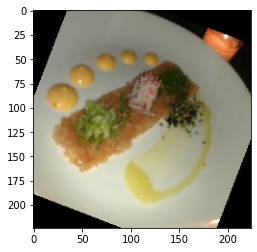

In [47]:
train_features, train_labels = next(iter(train_loader))
img = train_features[0].squeeze()
label = train_labels[0]
imshow(img);
print(f'Image label no.: {label}')

### 3. Create the model

First, because there are different architectures, we will need a dictionary to contain the architecture a.k.a the number of neurons at each layer.

In [35]:
VGG_TYPES = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}

Let's sneak a peek at the target model from PyTorch:

In [48]:
model = torchvision.models.vgg16()

In [49]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

There is a different between the pre-defined model in PyTorch and the model from the paper: there is an additional average pooling layer after all the convolution layers.

In [60]:
class VGG16_net(nn.Module):
    def __init__(self, in_channels=3, out_classess=101):
        super().__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_TYPES["VGG16"])
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 4096), # The 7*7 from the previous pooling layer
            nn.ReLU(), # I do not do it in place
            nn.Dropout(p=0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, out_classess)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x
    
    def create_conv_layers(self, arch):
        # Stack the layers into a list before passing to nn.Sequential
        layers = []
        in_channels = self.in_channels

        for layer in arch:
            if type(layer) == int:
                out_channels = layer

                layers.extend(
                    [nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1),
                     nn.BatchNorm2d(layer), # Invented after the original paper, but improve performance
                     nn.ReLU()
                     ]
                    
                )
                in_channels = layer
                # Number of output in the last layer is the number
                # of inputs for the next layer
            elif layer=='M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        return nn.Sequential(*layers)

In [95]:
model1 = VGG16_net().to(device)
model1

VGG16_net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [68]:
next(model1.parameters()).device

device(type='cuda', index=0)

### 4. Pick loss function, optimizer, metric

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.1)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [76]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               metric: Accuracy,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss & accuracy
        loss = criterion(y_pred, y)
        train_loss += loss
        train_acc += metric(y_pred.argmax(dim=1), y)

        # 3. Empty out gradient
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimize 1 step
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

In [77]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               metric: Accuracy,
               device: torch.device = device):
    test_loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for (X,y) in data_loader:
            X, y = X.to(device), y.to(device)
        # 1. Forward pass
            y_pred = model(X)

        # 2. Calculate loss & accuracy
            test_loss += criterion(y_pred, y)
            acc += metric(y_pred.argmax(dim=1), y)

        test_loss /= len(data_loader)
        acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {acc:.2f}")

In [92]:
del model1

NameError: ignored

In [94]:
gc.collect()
torch.cuda.empty_cache()

In [96]:
epochs = 2
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model1, 
        criterion=criterion,
        optimizer=optimizer,
        metric=accuracy,
        device=device
    )
    gc.collect()
    torch.cuda.empty_cache()
    test_step(data_loader=valid_loader,
        model=model1,
        criterion=criterion,
        metric=accuracy,
        device=device
    )
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 4.63904 | Train accuracy: 0.01


KeyboardInterrupt: ignored

On Colab, 1 epoch was trained for 15 minutes, with a phenomenal accuracy of 1 percent (before interruption).
On Kaggle, 1 epoch could not finish training due to memory run-out, but you could imagine a similar accuracy.
Clearly, this is not what we should do.

Create a model from scratch is great for learning, but it is impractical in developing applications (and sometimes in further research). It is better if we can make use of pre-trained model. With that, let's move on to transfer learning.